In [1]:
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy import hstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.utils import to_categorical
from keras.models import Model
from keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# https://github.com/tensorflow/tensorflow/issues/46038
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = tf.compat.v1.Session(config=config)

In [4]:
# load images
def load_real_samples():
    # load dataset
    (trainX, _), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape)
    return X
fgiudhfg = load_real_samples()
# select real samples
def generate_real_samples(dataset = fgiudhfg, n_samples = 256):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images and labels
    X = dataset[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

(60000, 28, 28, 1)


In [5]:
def show_real_examples(ds, ds_info):
    tfds.show_examples(ds, ds_info)

In [6]:
#Define the generator model:
# TODO add parametrization for the conv2dt layer shapes
def get_generator(input_size, ds_shape, kernel_initializer):
    input_latent = layers.Input(shape=(input_size))
    res=int(ds_shape[0]/4)
    depth=int(ds_shape[-1])

    n_nodes = 128 * res * res

    g = layers.Dense(n_nodes)(input_latent)
    g = layers.ReLU()(g)
    g = layers.BatchNormalization()(g)
    g = layers.Reshape((res, res, 128))(g)

    g = layers.Conv2D(64, 4, padding='same',activation='relu',kernel_initializer=kernel_initializer)(g)
    g = layers.ReLU()(g)
    g = layers.BatchNormalization()(g)

    g = layers.Conv2DTranspose(32, 4, strides=(2,2), padding='same',kernel_initializer=kernel_initializer)(g)
    g = layers.ReLU()(g)
    g = layers.BatchNormalization()(g)

    g = layers.Conv2DTranspose(depth, 4, strides=(2,2), padding='same',kernel_initializer=kernel_initializer)(g)
    output_layer = layers.Activation('sigmoid')(g)

    gen_model = Model(input_latent, output_layer)
    return gen_model

In [7]:
def get_discriminators(input_shape, kernel_initializer, qcodes, lr):
    input_image=layers.Input(shape=input_shape)

    l=layers.Conv2D(32, 4, strides=(2,2),padding='same',kernel_initializer=kernel_initializer)(input_image)
    l=layers.ReLU()(l)

    l=layers.Conv2D(64, 4, strides=(2,2), padding='same',kernel_initializer=kernel_initializer)(l)
    l=layers.ReLU()(l)
    l=layers.BatchNormalization()(l)

    l=layers.Conv2D(128, 4, strides=(2,2), padding='same',kernel_initializer=kernel_initializer)(l)
    l=layers.ReLU()(l)
    l=layers.BatchNormalization()(l)

    l=layers.Flatten()(l)
    #Classification head of the discriminator
    out=layers.Dense(1,activation='sigmoid')(l)
    discr_model = Model(input_image, out)
    discr_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    q = layers.Dense(128)(l)
    q = layers.BatchNormalization()(q)
    q = layers.LeakyReLU(alpha=0.1)(q)
    out_codes = layers.Dense(qcodes[0][0], activation='softmax')(q)
    q_model = Model(input_image, out_codes)
    return discr_model, [q_model]
#     out=layers.Dense(1,activation='sigmoid')(l)
#     discriminator_model = Model(input_image, out)
#     discriminator_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr, beta_1=0.5))
#     # create q model layers
#     q = layers.Dense(128)(l)
#     q = layers.BatchNormalization()(q)
#     q = layers.LeakyReLU(alpha=0.1)(q)
#     # q model output
#     q_models = []
#     for qcodedim, qcodetype in qcodes:
#         out_codes = layers.Dense(
#             qcodedim,
#             activation='softmax' if qcodetype == 'onehot' else 'sigmoid'
#         )(q)
#         q_models += [Model(input_image, out_codes)]
#     return discriminator_model, q_models

In [8]:
def get_infogan(G, D, Qs, Qtypes, lr):
    for layer in D.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = False
    discr_output = D(G.output)
    q_output = Qs[0](G.output)
    infogan_model = Model(G.input, [discr_output, q_output])
    opt = Adam(lr=0.0002, beta_1=0.5)
    infogan_model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return infogan_model
#     # make weights in the discriminator (some shared with the q model) as not trainable
#     for layer in D.layers:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = False
#     # connect g outputs to d inputs
#     discr_output = D(G.output)
#     # connect g outputs to q inputs
#     q_outputs = [q(G.output) for q in Qs]
#     # define composite model
#     infogan_model = Model(G.input, [discr_output, *q_outputs])
#     # compile model
#     opt = Adam(lr=lr, beta_1=0.5)
#     Qlosses = ['categorical_crossentropy' if qtype == 'onehot' else 'mse' for qtype in Qtypes]
#     infogan_model.compile(loss=['binary_crossentropy', *Qlosses], optimizer=opt)
#     return infogan_model

In [9]:
def generate_noise_and_codes(n_samples, zdim, qcodes):
    z=randn(n_samples, zdim)
    cat_codes = []
    for qdim, qtype in qcodes:
        if qtype == 'onehot':
            cat_codes += [np.eye(qdim)[np.random.choice(qdim, n_samples)]]
        else:
            cat_codes += [np.random.randn(qdim, n_samples)]
        z = hstack((z, cat_codes[-1]))
    return z, cat_codes

In [10]:
def generate_fake_samples(G, n_samples, zdim, qcodes):
    z, _ = generate_noise_and_codes(n_samples, zdim, qcodes)
    x = G.predict(z)
    y = zeros((n_samples, 1))
    return x, y

In [12]:
class InfoGAN:
    def __init__(
        self,
        dsname = 'mnist',
        qcodes = [(10, 'onehot')],
        latent_dim = 100,
        batch_size = 32,
        stddev = 0.02,
        lr = 1e-4
    ):
        self.batch_size     = batch_size
        ds                  = self.load(dsname)
        self.ds             = ds[0]
        self.ds_info        = ds[1]
        self.ds_shape       = ds[2]
        self.qcodes         = qcodes
        self.latent_dim     = latent_dim
        self.gen_input_size = self.latent_dim + sum([dim for dim, datatype in self.qcodes])
        self.kernel_init    = RandomNormal(stddev=0.02)
        self.lr             = lr
        self.gen            = get_generator(self.gen_input_size, self.ds_shape, self.kernel_init)
        self.disc, self.qs  = get_discriminators(self.ds_shape, self.kernel_init, self.qcodes, self.lr)
        self.model          = get_infogan(
            self.gen,
            self.disc,
            self.qs,
            [qtype for qdim, qtype in self.qcodes],
            self.lr
        )

    def normalize_img(self, image, _):
        return (tf.cast(image, tf.float32) - 127.5) / 127.5, 1

    def load(self, dsname):
        ds, ds_info = tfds.load(dsname, split='train', with_info=True,as_supervised=True)
        shape = ds_info.features['image'].shape
        ds = ds.map(self.normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        ds = ds.cache()
        # For true randomness, we set the shuffle buffer to the full dataset size.
        ds = ds.shuffle(ds_info.splits['train'].num_examples)
        # Batch after shuffling to get unique batches at each epoch.
        ds = ds.batch(self.batch_size)
        ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
        return ds,ds_info, shape

    # train the generator and discriminator
    def train(self, n_epochs=100):
        # calculate the number of batches per training epoch
        bat_per_epo = len(self.ds)
        # calculate the number of training iterations
        n_steps = bat_per_epo * n_epochs
        # manually enumerate epochs
        for e in range(n_epochs):
            for i in range(bat_per_epo):
                # update discriminator and q model weights
                x, y = generate_real_samples(n_samples = self.batch_size)
                d_loss1 = self.disc.train_on_batch(x, y)
                # generate 'fake' examples
                X_fake, y_fake = generate_fake_samples(self.gen, self.batch_size, self.latent_dim, self.qcodes)
                # update discriminator model weights
                d_loss2 = self.disc.train_on_batch(X_fake, y_fake)
                # prepare points in latent space as input for the generator
                z_input, cat_codes = generate_noise_and_codes(self.batch_size, self.latent_dim, self.qcodes)
                # create inverted labels for the fake samples
                y_gan = ones((self.batch_size, 1))
                # update the g via the d and q error
                _, *gan_losses = self.model.train_on_batch(z_input, [y_gan, *cat_codes])
                # summarize loss on this batch
                print('\r%d: %d/%d, d: %.6f & %.6f, g: %.6f q: %.6f ' % (e + 1, i+1, bat_per_epo, d_loss1, d_loss2, *gan_losses), end = '')
            print()
#                 # evaluate the model performance every 'epoch'
#                 if (i+1) % (bat_per_epo * 10) == 0:
#                     self.summarize_performance(i)

In [13]:
infogan = InfoGAN(batch_size = 128)
infogan.train(n_epochs=1)

1: 469/469, d: 0.000016 & 0.000230, g: 9.160370 q: 0.153281


In [14]:
def generate_latent_points_from_cat(latent_dim, codes):
    z_latent = randn(len(codes), latent_dim)
    z_input = hstack((z_latent, codes))
    return z_input

def generate_fake_samples_and_z_from_cat(generator, latent_dim, codes):
    z_input = generate_latent_points_from_cat(latent_dim, codes)
    images = generator.predict(z_input)
    return images

In [15]:
def plotSome(gen, latent_dim, codes):
    images = generate_fake_samples_and_z_from_cat(gen, latent_dim, codes)
    plt.subplots(figsize=(24, 24))
    for i in range(len(codes)):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.title(np.argmax(codes[i]))
        plt.imshow(images[i, :, :, 0], cmap='gray_r')
    plt.show()

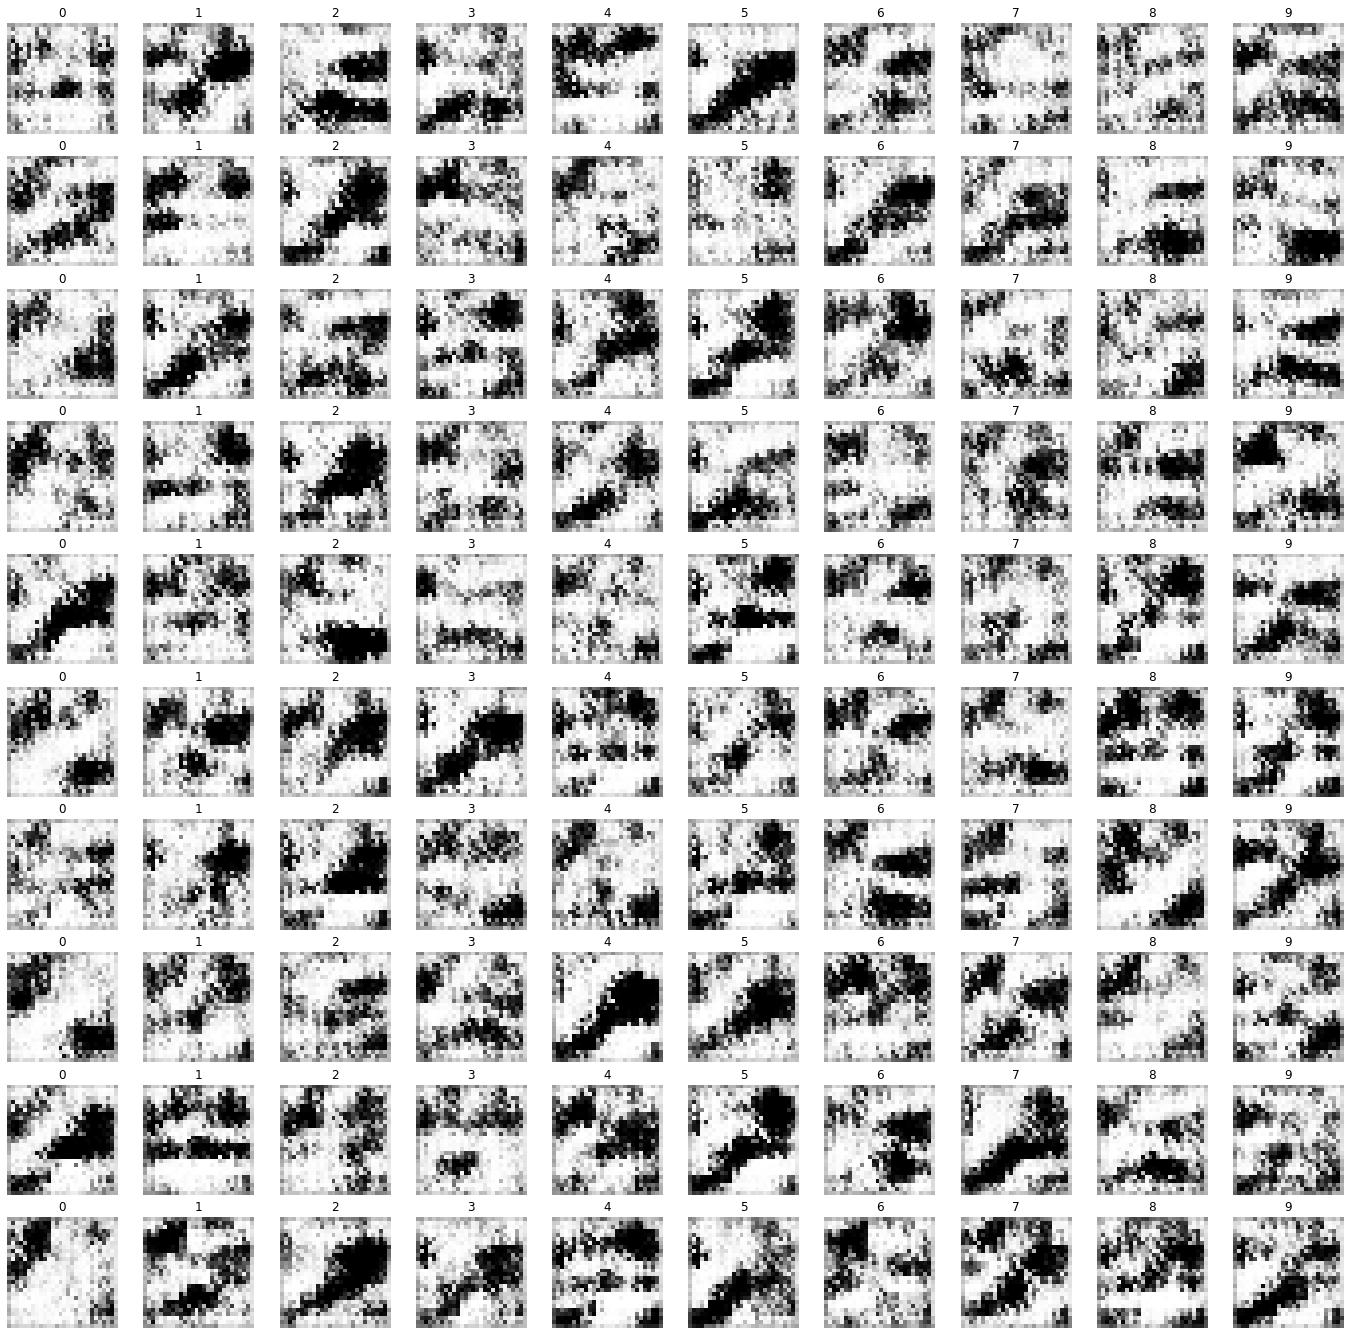

In [16]:
c1 = to_categorical([i % 10 for i in range(100)], 10)
plotSome(infogan.gen, infogan.latent_dim, c1)